In [1]:
import numpy as np
import matplotlib.pyplot as plt
from LIBSVM import LIBSVMLoader
from kernel import Kernel

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"
plt.rc('text', usetex=True)

np.random.seed(0)

In [3]:
def get_num(y):
    return y.argmax(axis=1)

def generate_random_sphere(n_train, m):
    u = np.random.randn(n_train, m)
    u /= np.sqrt(np.sum(u**2, axis=1))[:, np.newaxis]
    return u

def generate_random_coordinate(n_train, m):
    u = np.random.randn(n_train, m)
    return (u == u.max(axis=1)[:, np.newaxis]).astype(float)

def generate_random_sets(y_train_num, m=None):
    """Generate partial supervision from full supervision

    Generate sets represented as one hot encoding from full supervision represented with numbers.
    Choose a random set by sampling Bernouilli variables for the appartenance of each label to each set.
    """
    n_train = len(y_train_num)
    if m is None:
        m = np.max(y) + 1
    u = np.random.rand(n_train, m) > .5

    # Avoid trivial questions
    bad = np.ones(n_train, dtype=bool)
    while bad.any():
        bad[:] = np.abs(u.mean(axis=1) - .5) == .5
        u[bad] = np.random.rand(bad.sum(), m) > .5

    ind = u[np.arange(n_train), y_train_num]
    np.invert(ind, out=ind)
    u[ind] = np.invert(u[ind])
    return u

def get_stepsize(T, gamma_0=1):
    gamma = np.arange(T, dtype=float)
    gamma += 1
    np.sqrt(gamma, out=gamma)
    np.divide(1, gamma, out=gamma)
    gamma *= gamma_0
    return gamma


 usps 7291 256 10
0,1,2,3,4,

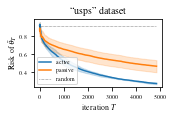

In [9]:
n_exp = 5
names = LIBSVMLoader.datasets
# names = ['dna', 'svmguide2']
names = ['svmguide2', 'svmguide4', 'glass', 'iris', 'vowel', 'wine', 'vehicle', 'dna', 'segment', 'sector']
names = ['pendigits', 'satimage', 'usps']
names = ['usps']

for name in names:
    loader = LIBSVMLoader(name)
    X, Y = loader.get_trainset()
    n, m = Y.shape
    d = X.shape[1]

    n_train = int(2 * n / 3)
    n_test = n - n_train

    print('\n', name, n, d, m)
    if n > 10**4:
        continue

    alpha = np.zeros((n_train, m), np.float32)
    average_alpha = np.zeros((n_train, m), np.float32)
    err = np.zeros((n_exp, n_train), np.float32)

    alpha_bis = np.zeros((n_train, m), np.float32)
    average_alpha_bis = np.zeros((n_train, m), np.float32)
    err_bis = np.zeros((n_exp, n_train), np.float32)

    if name == "usps":
        gamma_0 = 15
        amp = 4
    if name == "pendigits":
        gamma_0 = 7.5
        amp = 4
    if name == "satimage":
        gamma_0 = 10
        amp = 2
    gamma = get_stepsize(n_train, gamma_0)

    sigma = .2 * np.sqrt(d)
    kernel = Kernel('gaussian', sigma=sigma)
    K = np.zeros((n_train, n_train), dtype=np.float32)
    k_test = np.zeros((n_test, n_train), dtype=np.float32)

    gradient = np.empty(m, dtype=np.float32)
    y_pred = np.empty(m, dtype=np.float32)

    for j in range(n_exp):

        ind = np.random.choice(n, n_train, replace=False)
        x_train, y_train = X[ind], Y[ind]
        ind = ~np.isin(np.arange(n), ind)
        x_test, y_test = X[ind], Y[ind]

        kernel.set_support(x_train)
        K[:] = kernel(x_train)
        k_test[:] = kernel(x_test).T

        u = generate_random_sphere(n_train, m).astype(np.float32)
        s_train = generate_random_sets(get_num(y_train), m=m)

        alpha[:] = 0
        average_alpha[:] = 0

        alpha_bis[:] = 0
        average_alpha_bis[:] = 0

        for i in range(n_train):
            epsilon = np.sign(np.dot(K[i, :i+1] @ alpha[:i+1] - y_train[i], u[i]))
            alpha[i] -= epsilon * gamma[i] * u[i]
            average_alpha += alpha

            y_pred[:] = K[i, :i+1] @ alpha_bis[:i+1]
            gradient[:] = y_pred.copy()
            # Find best index inside the set
            y_pred[~s_train[i]] = np.min(y_pred) - 1
            i_star = y_pred.argmax()
            # L(z, S) = z - y_S^*
            gradient[i_star] -= 1
            gradient /= np.sqrt((gradient ** 2).sum())
            gradient *= amp * gamma[i]
            alpha_bis[i] -= gradient
            average_alpha_bis += alpha_bis
            
            y_num = get_num(k_test[:, :i+1] @ average_alpha[:i+1])
            y_num_bis = get_num(k_test[:, :i+1] @ average_alpha_bis[:i+1])
            err[j, i] = (y_num != get_num(y_test)).mean()
            err_bis[j, i] = (y_num_bis != get_num(y_test)).mean()

        print(j, end=',')

    ave_error = err.mean(axis=0)
    std_error = err.std(axis=0)
    ave_error_bis = err_bis.mean(axis=0)
    std_error_bis = err_bis.std(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.75))
    ax.fill_between(np.arange(n_train) + 1, ave_error + std_error, ave_error - std_error, color='C0', alpha=.2)
    a, = ax.plot(np.arange(n_train) + 1, ave_error, c='C0')
    ax.fill_between(np.arange(n_train) + 1, ave_error_bis + std_error_bis, ave_error_bis - std_error_bis, color='C1', alpha=.2)
    b, = ax.plot(np.arange(n_train) + 1, ave_error_bis, c='C1')
    c, = ax.plot(np.arange(n_train) + 1, np.full(n_train, 1 - 1/m), c='k', linestyle='dotted', lw=.5)
    ax.legend([a, b, c], ['active', 'passive', 'random'], prop={'size': 6})
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_title(r"``" + name + r"'' dataset", size=10
    )
    ax.set_xlabel(r"iteration $T$", size=8)
    ax.set_ylabel(r"Risk of $\bar\theta_T$", size=8)
    fig.tight_layout()
    fig.savefig("classification_{}_best.pdf".format(name))